# Do More with Twitter Data

Twitter is what's happening and what people are talking about right now, with hundreds of millions of Tweets sent each day.

## Intro

Often, when people think about conducting analysis on data from Twitter, they think analyzing Tweet content. While this is a rich collection of data, another important dimension in which to think about Twitter data analysis is that of its *users*. 

Twitter users post all sorts of interesting content in Tweets, but they also frequently share information about themselves by way of their account profile. If you visit [this author's profile](https://twitter.com/jrmontag), you'll find a handful of data points that are not Tweet-related, but user-related. Among other things, you might find geographical data, pointers to other websites, and a free-text profile description e.g. "counts 🐥💬, drinks ☕️, takes 📷, climbs 🗻". This is data that a user may not regularly Tweet about, and which you would miss if you were only looking at their posted content.


In this notebook, we're going to look at how to use the Twitter Search APIs to collect data around a cultural topic, and then use the resulting data to learn something interesting about the users participating in that discussion. Specifically, we'll look for clusters of similar users among all of the users we identify. Along the way, we'll look at some of the ways that you can make the journey from the collection of JSON data, processing relevant elements of each Tweet, engineering features that can be used for model training, and finally, inspecting the results of our models to see what we've learned.


This notebook will follow the outline below:

- data collection
- data inspection
- feature engineering
    - source data
    - preprocessing
    - tokenization
    - stopwords
    - vectorization
- selecting and tuning a model
- inspecting a model
- model iteration

## Environment Setup
First, some imports.

In [2]:
from collections import Counter
import itertools as it
import json
import logging
import os
import re
import string
import sys

from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256
import hdbscan
import matplotlib.pyplot as plt
from nltk.util import everygrams
from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from stop_words import get_stop_words
from tweet_parser.tweet import Tweet
from searchtweets import load_credentials, gen_rule_payload, collect_results
# from MulticoreTSNE import MulticoreTSNE as TSNE
import yaml

Loading BokehJS ...

# Data Collection

We'll use the [2019 Sep Democratic Debate](https://www.youtube.com/watch?v=2UWVO0Trd1c) as our topic. Ultimately we are interested in those users who are Tweeting about the debate, so we start by looking for relevant Tweets and then we'll dig into the users behind those Tweets.

When in doubt, it's a reasonable strategy to start broad and simple with our rule - in this case we can simply use "democraticdebate". After inspecting the data we can refine the rule (and resulting data) in the name of increasing it's relevance to the task at hand.

In [3]:
import json
import tweepy
from access_keys import ACCESS_TOKEN, ACCESS_SECRET, CONSUMER_KEY, CONSUMER_SECRET
import csv
import datetime

In [4]:
#Function to Extract Tweets
def get_topic_tweets(file_name, topic=None, date_start=None, date_end=None, num_tweets = 1000):
    
    """
    Function to call twitter api for tweet data using tweepy
    file_name: user required name as .csv
    topic: topic of interest typically begins with #
    date_start: start date as string 'YYYY-MM-DD'
    date_end:   end date as string 'YYYY-MM-DD'
    num_tweets: number of tweets to request from API
    """
    
    #Authrization to consumer key and consumer secret
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    
    #Access to user's access key and access secret
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    #Calling api
    api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    
    #Number of tweets to be extracted
    number_of_tweets = num_tweets  
    
    
    #Open/Create a file to append data
    with open(file_name, 'w', encoding='UTF-8') as outfile:
    
        csvWriter = csv.writer(outfile)
        
        #Define Column Names To Write To
        csvWriter.writerow(['time_stamp','tweet_text', 'url', 'user_id', 'user_name', 'user_screen_name',
                            'user_bio','user_location'])
        
        #Topic_To_Choose_From
        for tweet in tweepy.Cursor(api.search, q=topic, lang='en', tweet_mode="extended", 
                                   include_entities=True, since=date_start, until=date_end).items(num_tweets): 
            
            #Write Data to CSV 
            csvWriter.writerow([tweet.created_at, tweet.full_text, tweet.entities['urls'], 
                                tweet.user.id, tweet.user.name, tweet.user.screen_name, tweet.user.description, tweet.user.location])

In [ ]:
get_topic_tweets(file_name="election_2020_1000.csv",topic='DemocraticDebate ', date_start = '2019-09-12', date_end = '2019-09-13', num_tweets=1000)

# Data Inspection

Great, now we have some data to work with. Importantly, the first step is always to inspect the data. Is it what you were expecting? Is it relevant? Are there sources of noise you can negate in your rule? All of these issues can be addressed by iterating on your filters and inspecting the results.

Additionally, since we intentionally capped the number of total Tweets, it's good to inspect the time series of data to see what range it covers.

Since Tweets are automatically parsed we can use some of the convenient attributes to pull out the text data. 

In [5]:
#Read in tweet data
tweet_df = pd.read_csv('election_2020_1000.csv')

tweet_df.head()

,time_stamp,tweet_text,url,user_id,user_name,user_screen_name,user_bio,user_location
0,2019-09-12 23:59:59,RT @cthulhu4america: Yet another night full of...,[],3092678020,Darick Oswalt ✈️ 🔜 TwitchCon,thatCHARM3R,Freelance #esports talent. #Twitch & #Discord ...,"Michigan, USA"
1,2019-09-12 23:59:59,RT @YangGang20206: I'm loving everyone's #MyYa...,[],701111114931707905,StarshipYang,RichardJKilshaw,#YangGang #yangbot 1 Elon Musk puts YANG2020...,"Portland, OR"
2,2019-09-12 23:59:58,RT @KyleKulinski: ABC News hosts are saying de...,[],2596659379,Cooper,pripensi_en,"college student, civil libertarian, humanist, ...",United States
3,2019-09-12 23:59:58,RT @KyleKulinski: ABC News hosts are saying de...,[],2916428957,Eric Gillikin 🌹,Eriquimus_Prime,A friend to most. Retweets + links are not end...,United States
4,2019-09-12 23:59:58,RT @DrewBiemer: It’s clear that @TheDemocrats ...,[],3582790755,DejaVu,Anonymous603207,NaN,NaN


In [6]:
tweet_df.dtypes

time_stamp          object
tweet_text          object
url                 object
user_id              int64
user_name           object
user_screen_name    object
user_bio            object
user_location       object
dtype: object

In [7]:
#Convert object type to datetime stamp
tweet_df['time_stamp'] = pd.to_datetime(tweet_df['time_stamp'], errors='coerce');

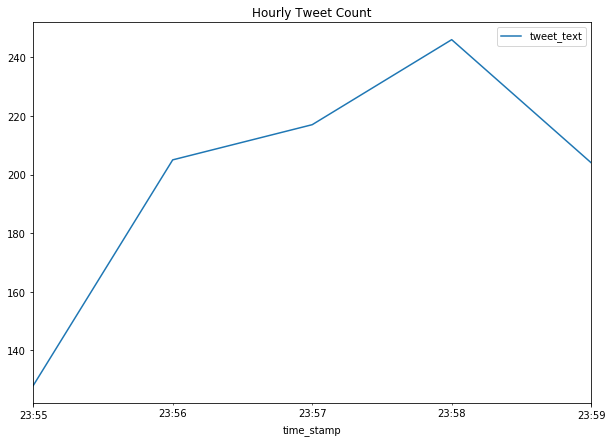

In [8]:
#Plot a time series
(tweet_df[['time_stamp','tweet_text']].set_index('time_stamp')
 # 'T' = minute
 .resample('T')
 .count()
 .plot(figsize=(10,7), label='1-Hour Counts', title='Hourly Tweet Count')
);

Given the `num_tweets` we added we have a short time span for now. Our data colletion starts at the end date and works backwords until hitting the maximum result count. That's OK, we'll collect more data later.

With this small sample, let's do a bit of rough text processing to look at the text we're seeing in these Tweets. A simple - and often, informative - first way to inspect the content of text data is through looking at the most common n-grams. In language modeling, an "n-gram" is a contiguous collection of some n items - in languages where appropriate, this is often white-space separated words. For example, two-grams in the sentence "The dog ate my homework" would be "the dog", "dog ate", "ate my", "my homework".

We'll use the all_text attribute of our Tweet objects to simply pull in all the text, regardless of whether it was a Retweet, original Tweet, or Quote Tweet. Then we'll concatenate all the Tweet text together (from the whole corpus), split it up into words using an open-source tokenizer from NLTK (we'll talk more about this, shortly), remove some punctuation, and then simply count the most common set of n-grams.

This is a very rough (but quick) way of getting a feel for the text data we have. If we see content that we don't think is relevant, we can go back and modify our rule.

### Clean Words

In [9]:
# Text preprocessing steps - remove numbers, captial letters and punctuation from article text and title
import re
import string
import demoji #Will remove and place all emoji's in individual column for analysis
demoji.download_codes() 
#The emoji list itself is frequently updated and changed. Periodically update local cache.

def Find_Url(string): 
    """
    Function to find URLs within tweets using regex expression
    """
    url = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+] \
    |[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', string) 
    
    return url

#Extract Emojis
find_emoji = lambda x: demoji.findall(x)
tweet_df['tweet_emoji'] = tweet_df.tweet_text.map(find_emoji)

#Remove urls
tweet_df.tweet_text = tweet_df.tweet_text.apply(Find_Url)

#Remove Usernames, topics, references
remove_username = lambda x: re.sub('RT @[^\s]+','',x)
remove_at_sign = lambda x: x.replace('@','') #Will Maintain Canidate Name
remove_topic = lambda x: re.sub('#[^\s]+','',x)
remove_emoji = lambda x: demoji.replace(x,'')

#Strip text of punctuation, and extract spaces

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' %re.escape(string.punctuation), ' ', x.lower())
odd_replacements = {"…": "''","“": "''","’": "''","”": "''", "''":''}
remove_odd = lambda x: "".join([odd_replacements.get(c,c) for c in x])

#Remove ABC News from text as the station broadcasted the debate and will most likely be referenced frequently
excess_words =['abc', 'news']
remove_abc = lambda x: ' '.join([word for word in x.split() if word not in (excess_words)])

... OK (Got response in 0.29 seconds)
Writing emoji data to C:\Users\moham\.demoji/codes.json ...
... OK


In [10]:
#Apply Filters Function
def apply_fitlers(df =None, df_input_column_name =None, df_output_column_name=None):
    """ Function to apply cleaning filters defined above
        df : data frame 
        df_input_column_name : dataframe column filters will be applied to as str
        df_output_column_name: output dataframe column as str
    """
    df[df_output_column_name] = df[df_input_column_name].map(remove_username).map(remove_at_sign).map(remove_topic) \
    .map(remove_emoji).map(remove_odd).map(alphanumeric).map(punc_lower).map(remove_abc)
    
    return df

In [11]:
apply_fitlers(df=tweet_df, df_input_column_name='tweet_text', df_output_column_name='tweet_text_cleaned');

### Tokenize and Remove StopWords

In [12]:
def remove_lang_stop_words_and_tokenize(lang ='english',df=None,column=None):
    """
    Function to remove langauge stop words and tokenize column text
    language: Default is english, 21+ languages supported by NLTK, choose language of choice
    df: text containing dataframe
    column: column to modify as string example 'tweet_text'
    """
    # Define English Stop Words
    stop_words = set(stopwords.words(lang))
    
    #Tokenize Text and remove english stop words
    df[column] = df[column].apply(word_tokenize).apply(lambda x: [item for item in x if item not in stop_words])
    
    #Detokenize text back into string
    detokenize_text = lambda x: TreebankWordDetokenizer().detokenize(x)
    
    df[column] = df[column].map(detokenize_text)
    
    return df

In [13]:
#Tokenize Text and remove english stop words
remove_lang_stop_words_and_tokenize(lang='english',df=tweet_df,column='tweet_text_cleaned');

### Check n-gram tweets without stop words 

In [14]:
def get_all_tokens(tweet_list):
    """
    Helper function to generate a list of text tokens from concatenating
    all of the text contained in Tweets in 'tweet_list'
    """
    
    #concat entire corpus
    all_text = tweet_list.str.cat(sep=' ')
    
    #remove 
    
    #tokenize
    tokens = (TweetTokenizer(preserve_case=False,
                            reduce_len=True,
                            strip_handles=False)
             .tokenize(all_text))
    #Remove symbol-only tokens for now
    tokens = [tok for tok in tokens if not tok in string.punctuation]
    return tokens

In [15]:
tweets_without_stopwrds = tweet_df.tweet_text_cleaned

In [16]:
tokens = get_all_tokens(tweets_without_stopwrds)

print('Total Number Of Tokens: {}'.format(len(tokens)))

Total Number Of Tokens: 8883


In [17]:
#Calculate a range of ngrams using some handy functions
top_grams = Counter(everygrams(tokens, min_len=2, max_len=4))

top_grams.most_common(25)

[(('turned', 'first'), 65),
 (('first', 'thing'), 65),
 (('thing', 'hear'), 65),
 (('hear', 'debate'), 65),
 (('debate', 'policy'), 65),
 (('policy', 'specifics'), 65),
 (('specifics', 'energy'), 65),
 (('energy', 'id'), 65),
 (('turned', 'first', 'thing'), 65),
 (('first', 'thing', 'hear'), 65),
 (('thing', 'hear', 'debate'), 65),
 (('hear', 'debate', 'policy'), 65),
 (('debate', 'policy', 'specifics'), 65),
 (('policy', 'specifics', 'energy'), 65),
 (('specifics', 'energy', 'id'), 65),
 (('turned', 'first', 'thing', 'hear'), 65),
 (('first', 'thing', 'hear', 'debate'), 65),
 (('thing', 'hear', 'debate', 'policy'), 65),
 (('hear', 'debate', 'policy', 'specifics'), 65),
 (('debate', 'policy', 'specifics', 'energy'), 65),
 (('policy', 'specifics', 'energy', 'id'), 65),
 (('talking', 'banning'), 43),
 (('banning', 'double'), 43),
 (('double', 'cheese'), 43),
 (('cheese', 'burgers'), 43)]

Using these top n-grams, we can see the phrases " turned first, thing hear, talking banning, co" were very common during the debate. This adds noise to the data along with the viral discussiong regarding burgers and fries floating around during the campaign indicating individuals were very interested in this gag tweet

In [18]:
# Create a filter series matching "banning"
searchfor = ['thing','banning','co']
mask_1 = tweet_df.tweet_text_cleaned.str.lower().str.contains('|'.join(searchfor))

#Check number of tweets that are creating noise
print(tweet_df[mask_1][['tweet_text_cleaned']].shape)

(506, 1)


These tweets don't appear to be on topic as the most common tokens appear to have a lot of noise. We will remove allt tweets with the mask applied above and rerun our n-gram efforts

In [19]:
tweet_df = tweet_df[~mask_1].reset_index(drop=True)

In [20]:
#Recheck tokens
tweets_without_noise = tweet_df.tweet_text_cleaned

In [21]:
tokens = get_all_tokens(tweets_without_noise)

print('Total Number Of Tokens: {}'.format(len(tokens)))

Total Number Of Tokens: 4240


In [22]:
#Calculate a range of ngrams using some handy functions
top_grams = Counter(everygrams(tokens, min_len=2, max_len=4))

top_grams.most_common(25)

[(('elizabeth', 'warren'), 24),
 (('see', 'andrewyang'), 16),
 (('forward', 'hearing'), 16),
 (('bernie', 'sanders'), 16),
 (('excited', 'see'), 15),
 (('excited', 'see', 'andrewyang'), 15),
 (('retweet', 'excited'), 14),
 (('andrewyang', 'tonight'), 14),
 (('tonight', 'look'), 14),
 (('look', 'forward'), 14),
 (('hearing', 'say'), 14),
 (('every', 'democrat'), 14),
 (('democrat', 'running'), 14),
 (('retweet', 'excited', 'see'), 14),
 (('see', 'andrewyang', 'tonight'), 14),
 (('andrewyang', 'tonight', 'look'), 14),
 (('tonight', 'look', 'forward'), 14),
 (('look', 'forward', 'hearing'), 14),
 (('forward', 'hearing', 'say'), 14),
 (('every', 'democrat', 'running'), 14),
 (('retweet', 'excited', 'see', 'andrewyang'), 14),
 (('excited', 'see', 'andrewyang', 'tonight'), 14),
 (('see', 'andrewyang', 'tonight', 'look'), 14),
 (('andrewyang', 'tonight', 'look', 'forward'), 14),
 (('tonight', 'look', 'forward', 'hearing'), 14)]

Removing noisy tweets exposed underlying trends in the tweets which are more representative of potential topics in the debate with `elizabeth warren` frequently appearing in texts along with `joe biden`, `running president`, `abortion birth`.

We will now gather additional tweet data to run the rest of our analysis

In [ ]:
get_topic_tweets(file_name="election_2020_15000.csv",topic='DemocraticDebate ', date_start = '2019-09-12', date_end = '2019-09-13', num_tweets=15000)

Let's do our quick inspection process again. We'll print out our n-grams and a time-series plot of minute-duration counts.

In [ ]:
#Read in tweet data
tweet_df = pd.read_csv('election_2020_15000.csv')

tweet_df.head()

In [ ]:
tweet_df.dtypes

In [ ]:
#Convert object type to datetime stamp
tweet_df['time_stamp'] = pd.to_datetime(tweet_df['time_stamp'], errors='coerce');

In [ ]:
#Plot a time series
(tweet_df[['time_stamp','tweet_text']].set_index('time_stamp')
 # 'T' = minute
 .resample('T')
 .count()
 .plot(figsize=(10,7), label='1-Hour Counts', title='Hourly Tweet Count')
);

In [ ]:
#Remove Urls
tweet_df.tweet_text = tweet_df.tweet_text.apply(Find_Url)

#Apply Filters To New Data
apply_fitlers(tweet_df, 'tweet_text', 'tweet_text_cleaned');

In [ ]:
#Tokenize Text and remove english stop words
remove_lang_stop_words_and_tokenize(lang='english',df=tweet_df,column='tweet_text_cleaned');

In [ ]:
#Remove tweets that include discusson of burgers
# Create a filter series matching "banning"
mask = tweet_df.tweet_text_cleaned.str.lower().str.contains("banning")

#Check number of tweets that are creating noise
print(tweet_df[mask][['tweet_text_cleaned']].shape)

tweet_df = tweet_df[~mask].reset_index(drop=True)

tweets_without_noise = tweet_df.tweet_text_cleaned

In [ ]:
tokens = get_all_tokens(tweets_without_noise)

print('Total Number Of Tokens: {}'.format(len(tokens)))

In [ ]:
#Calculate a range of ngrams using some handy functions
top_grams = Counter(everygrams(tokens, min_len=2, max_len=4))

top_grams.most_common(25)

Now we can see that our first query was way out in the small tail of data volumne (to the X in our chart, toward the chosen end date). Our query now moves further back into the large-volume region. Event with a Tweet count limit of many thousands, we're still only covering a few hours of the last day!

Given both the narrow timeframes and X, it's possible that our data collection will be heavily weighted towards a canidate. If we collected the data back to the beginning of the debate, we would likely see additional topics surface in our analysis, and possible better represent the full bredth of discussion around the debate. 

Nevertheless, we can still move forward with our modeling. Let's set the stage by asking, simply: how many users are we looking at?

In [ ]:
unique_user_cnt = len(set(tweet_df['uid']))

Now that we have a bunch of useful data, let's see what kinds of groups of users we can identify in this collection. 

The first thing we'll do is step back to reconsider those rudimentary processing procedures we just used, and add some sophistication.

## Source data
We're going to apply clustering algorithms (a form of unsupervised learning) to a set of users and some of the text data that represents them, and there are many ways of consolidating some amount of data to represent a single user. You could use the users' most recent (single) Tweet, their most recent 30-days worth of Tweets (concatenated in one long string), you could pull out all of the URLs users shared, or the other users that they mentioned explicitly in their Tweets.

For this example, we'll represent each user by the free-form text field that the user manually enters in their profile to describe themselves, commonly called the "user bio" or the "bio." 